<a href="https://colab.research.google.com/github/Ratnasari124/Mechine_Learning_Ratnasari/blob/main/Ratnasari_2241720007_Mesin_Learning__JS_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Job Sheet 10**

Recurrent Neural Network (RNN)


---

Anggota Kelompok :      
- Lalu Immaratul Ardhi Ganeru 	(2241720169)
- M. Kemal Nugraha 			(2241720044)
- M. Ariel Saputra 			(2241720034)
- Ratnasari 				(2241720007)
---
Link Jobsheet : https://polinema.gitbook.io/jti-modul-praktikum-pembelajaran-mesin/job-sheet-10-recurrent-neural-network-rnn


# **PRAKTIKUM 1**

---

RNN untuk Analisis Sentimen

In [ ]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline

---



Download dataset menggunakan TFDS. Lihat loading text tutorial jika ingin me load data secara manua

In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Awalnya ini mengembalikan dataset (teks, pasangan label):

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Berikutnya acak data untuk pelatihan dan membuat kumpulan pasangan (teks, label) ini:

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

def cast_to_object(text, label):
  return tf.cast(text, tf.string), tf.cast(label, tf.int64)  # Or any desired dtype

train_dataset = train_dataset.map(cast_to_object)
test_dataset = test_dataset.map(cast_to_object)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


texts:  [b'I might not have been the biggest Blair Witch fan but nonetheless appreciated that effort, so I was looking forward to Altered, especially after reading the superlatives thrown around in various IMDb comments. "Unique", "intelligent", "A future cult classic" and so on... you gotta wonder where people come up with that stuff to describe such a poor effort.<br /><br />Because alas, Altered is a poor, weak movie that fails to engage in any and every respect. The silliness is not funny. The horror and gore is not scary. And whatever "thinking" aspect some poor fellows saw in this movie were due to severe delusions because there\'s certainly nothing profound or smart about this mess.<br /><br />OK, so we know nothing stands out. Is it at least bearable? Is the experience worthwhile in any way? Unfortunately, no. For starters, get very poor acting. It\'s not a stretch to say most B-movies these days feature better acting. The plot? Boring and messy. Dialogs? Many amateurs actually

Buat Teks Encoder

---



In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
vocab=np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [ ]:
encoded_example=encoder(example)[:3].numpy()
encoded_example

array([[ 10, 227,  22, ...,   0,   0,   0],
       [ 29,  44,   6, ...,   0,   0,   0],
       [ 64,   5,   4, ...,   0,   0,   0]])

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'I might not have been the biggest Blair Witch fan but nonetheless appreciated that effort, so I was looking forward to Altered, especially after reading the superlatives thrown around in various IMDb comments. "Unique", "intelligent", "A future cult classic" and so on... you gotta wonder where people come up with that stuff to describe such a poor effort.<br /><br />Because alas, Altered is a poor, weak movie that fails to engage in any and every respect. The silliness is not funny. The horror and gore is not scary. And whatever "thinking" aspect some poor fellows saw in this movie were due to severe delusions because there\'s certainly nothing profound or smart about this mess.<br /><br />OK, so we know nothing stands out. Is it at least bearable? Is the experience worthwhile in any way? Unfortunately, no. For starters, get very poor acting. It\'s not a stretch to say most B-movies these days feature better acting. The plot? Boring and messy. Dialogs? Many amateurs actual

## Buat Model


---



In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [ ]:
# # predict on a sample text without padding.

# sample_text = ('The movie was cool. The animation and the graphics '
#                'were out of this world. I would recommend this movie.')
# predictions = model.predict(np.array([sample_text]))
# print(predictions[0])

In [ ]:
# # predict on a sample text with padding

# padding = "the" * 2000
# predictions = model.predict(np.array([sample_text, padding]))
# print(predictions[0])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(train_dataset, epochs=10, validation_data=test_dataset, validation_steps=30)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 32s 64ms/step - accuracy: 0.5067 - loss: 0.6834 - val_accuracy: 0.7469 - val_loss: 0.5412
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 37s 61ms/step - accuracy: 0.7991 - loss: 0.4532 - val_accuracy: 0.8510 - val_loss: 0.3800
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 61ms/step - accuracy: 0.8463 - loss: 0.3513 - val_accuracy: 0.8698 - val_loss: 0.3142
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 61ms/step - accuracy: 0.8579 - loss: 0.3274 - val_accuracy: 0.8505 - val_loss: 0.3359
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 62ms/step - accuracy: 0.8639 - loss: 0.3140 - val_accuracy: 0.8620 - val_loss: 0.3154
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 24s 61ms/step - accuracy: 0.8663 - loss: 0.3090 - val_accuracy: 0.8552 - val_loss: 0.3193
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 61ms/step - accuracy: 0.8730 - loss: 0.2955 - val_accuracy: 0.8641 - val_loss: 0.3020
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 61ms/step - accuracy: 0.8702 - loss: 0.2967 - 

## Train Model

In [ ]:
# history = model.fit(train_dataset, epochs=10,
#                     validation_data=test_dataset,
#                     validation_steps=30)

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.8475 - loss: 0.3226
Test Loss: 0.3244406580924988
Test Accuracy: 0.8461199998855591


(0.0, 0.6656707808375358)

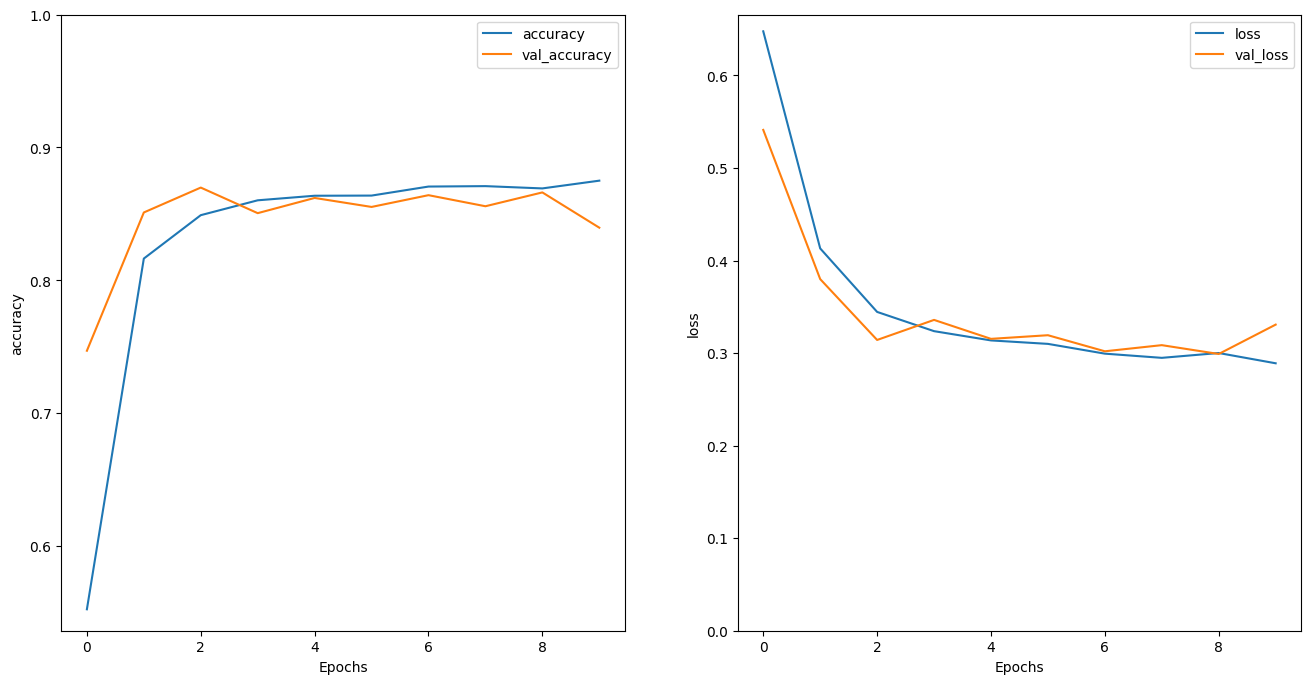

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
# sample_text = ('The movie was cool. The animation and the graphics '
#                'were out of this world. I would recommend this movie.')
# sample_text = encoder(sample_text)
# predictions = model.predict(np.array([sample_text]))

## Stack two or more LSTM layers

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 48s 109ms/step - accuracy: 0.5045 - loss: 0.6878 - val_accuracy: 0.7500 - val_loss: 0.4734
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 43s 108ms/step - accuracy: 0.7895 - loss: 0.4383 - val_accuracy: 0.8396 - val_loss: 0.3458
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 81s 106ms/step - accuracy: 0.8477 - loss: 0.3530 - val_accuracy: 0.8385 - val_loss: 0.3477
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 85s 113ms/step - accuracy: 0.8592 - loss: 0.3296 - val_accuracy: 0.8417 - val_loss: 0.3382
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 45s 113ms/step - accuracy: 0.8592 - loss: 0.3250 - val_accuracy: 0.8443 - val_loss: 0.3184
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 81s 111ms/step - accuracy: 0.8659 - loss: 0.3129 - val_accuracy: 0.8432 - val_loss: 0.3459
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 44s 112ms/step - accuracy: 0.8654 - loss: 0.3108 - val_accuracy: 0.8698 - val_loss: 0.3146
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 81s 109ms/step - accuracy: 0.8682 - loss: 0

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 ━━━━━━━━━━━━━━━━━━━━ 25s 64ms/step - accuracy: 0.8564 - loss: 0.3152
Test Loss: 0.3153032958507538
Test Accuracy: 0.8563600182533264


In [ ]:
# # predict on a sample text without padding.

# sample_text = ('The movie was not good. The animation and the graphics '
#                'were terrible. I would not recommend this movie.')
# predictions = model.predict(np.array([sample_text]))
# print(predictions)

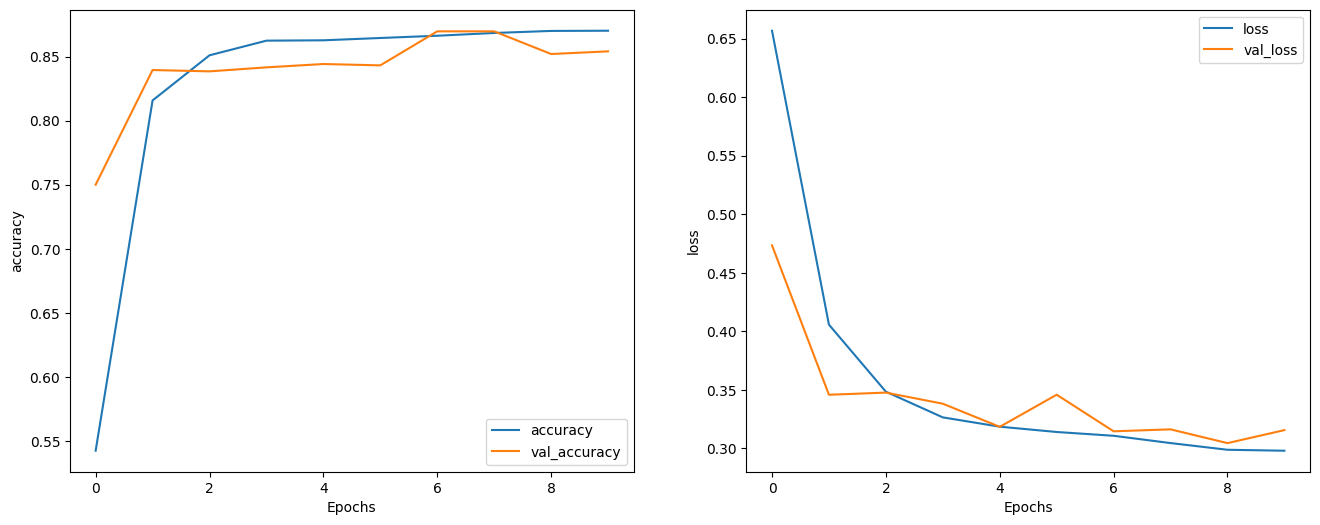

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

#**PRAKTIKUM 2**


---

Generator Teks dengan RNN


**Setup**

Import TensorFlow

In [ ]:
import tensorflow as tf
import numpy as np
import os
import time

In [ ]:
path_to_file = tf.keras.utils.get_file(
    'shakespeare.txt',  # This should be the filename you want to save it as
    origin='https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt'  # This is the URL of the file
)

1115394/1115394 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Load Data

In [ ]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [ ]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [ ]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


**Olah Teks**

Vectorize Teks


In [ ]:
example_texts=['abcdefg', 'xyz']
chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [ ]:
ids_from_chars = tf.keras.layers.StringLookup(
vocabulary=list(vocab), mask_token=None)

In [ ]:
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

In [ ]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [ ]:
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [ ]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [ ]:
def text_from_ids(ids):
    return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

In [ ]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [ ]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [ ]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [ ]:
seq_length = 100

In [ ]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


In [ ]:
for seq in sequences.take(5):
    print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


In [ ]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [ ]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [ ]:
dataset = sequences.map(split_input_target)

In [ ]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


**Membuat Batch Training**

In [ ]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

### **Buat Model**

In [ ]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [ ]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__()
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      # Fix: Initialize the state with the correct shape using tf.zeros
      batch_size = tf.shape(x)[0]
      states = tf.zeros([batch_size, self.gru.units], dtype=tf.float32) # Initialize with zeros and correct shape

    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [ ]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

### **Uji Model**

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


In [ ]:
model.summary()

Model: "my_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (64, 100, 256)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ ((64, 100, 1024), (64,      │       3,938,304 │
│                                      │ 1024))                      │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (64, 100, 66)               │          67,650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,022,850 (15.35 MB)

 Trainable params: 4,022,850 (15.35 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

In [ ]:
sampled_indices

array([ 3,  8, 28, 24, 16, 55, 34, 21,  6,  7, 13, 18, 18, 44, 16, 10, 15,
       52,  4, 22, 31, 35,  9, 28, 12, 36,  8, 28, 19, 39, 46, 29, 58, 18,
       56, 65, 65, 12, 38, 41, 18,  4, 17, 45, 29, 50, 22, 65,  2, 54, 39,
       54, 60, 30, 18, 29, 43, 17, 49, 10,  1, 30,  1, 54, 32, 44, 50, 51,
        6, 14, 11, 38, 11, 64, 17,  3, 59, 16, 45, 35, 44, 45, 43, 50, 44,
        2, 65, 60, 55, 11, 59, 62, 61, 10, 27, 20,  8, 32,  6, 58])

In [ ]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b'\nmany of us: that we did, we did for the best; and\nthough we willingly consented to his banishment, '

Next Char Predictions:
 b"!-OKCpUH',?EEeC3Bm$IRV.O;W-OFZgPsEqzz;YbE$DfPkIz oZouQEPdDj3\nQ\noSekl'A:Y:yD!tCfVefdke zup:twv3NG-S's"


**Train Model**

Tambahan optimizer dan fungsi loss


In [ ]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.1898894, shape=(), dtype=float32)


In [ ]:
tf.exp(example_batch_mean_loss).numpy()

66.01549

In [ ]:
model.compile(optimizer='adam', loss=loss)

Konfigurasi Cekpoints

In [ ]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

# Add .weights.h5 to the filename
checkpoint_prefix += ".weights.h5"  # This line is the fix

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

Lakukan Proses Training


In [ ]:
EPOCHS = 20

In [ ]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/20
 13/172 ━━━━━━━━━━━━━━━━━━━━ 15:56 6s/step - loss: 4.3398

KeyboardInterrupt: 

### **Generate Teks**

In [ ]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model  # Changed model8 to model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [ ]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

**Ekspor Model Generator**

In [ ]:
tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')

In [ ]:
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(100):
  next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
  result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))

# **TUGAS**

In [ ]:
class CustomTraining(MyModel):
  @tf.function
  def train_step(self, inputs):
      inputs, labels = inputs
      with tf.GradientTape() as tape:
          predictions = self(inputs, training=True)
          loss = self.loss(labels, predictions)
      grads = tape.gradient(loss, model.trainable_variables)
      self.optimizer.apply_gradients(zip(grads, model.trainable_variables))

      return {'loss': loss}

In [ ]:
EPOCHS = 10

mean = tf.metrics.Mean()

for epoch in range(EPOCHS):
    start = time.time()

    mean.reset_state()
    for (batch_n, (inp, target)) in enumerate(dataset):
        logs = model.train_step([inp, target])
        mean.update_state(logs['loss'])

        if batch_n % 50 == 0:
            template = f"Epoch {epoch+1} Batch {batch_n} Loss {logs['loss']:.4f}"
            print(template)

    # saving (checkpoint) the model every 5 epochs
    if (epoch + 1) % 5 == 0:
        model.save_weights(checkpoint_prefix.format(epoch=epoch))

    print()
    print(f'Epoch {epoch+1} Loss: {mean.result().numpy():.4f}')
    print(f'Time taken for 1 epoch {time.time() - start:.2f} sec')
    print("_"*80)

model.save_weights(checkpoint_prefix.format(epoch=epoch))